In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import meerkat as mk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from domino.data.cxr import get_dp, build_cxr_df, get_cxr_activations, rle2mask
from domino.feedback import ScribbleModel

In [3]:
# Get a mosaic DataPanel with the data.
df = build_cxr_df.out(load=True)
dp = get_dp(df)
dp.head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),input2 (CellColumn),img (CellColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...


In [4]:
train_dp = mk.DataPanel.read("/media/4tb_hdd/siim/feedback/06-24_khaled_cxr_fb.dp")
train_dp = mk.merge(train_dp, dp, how="inner", on="image_id")
train_dp["feedback_mask"] = train_dp["feedback_mask"][:]

In [5]:
negmask_dp = mk.DataPanel.read("/media/4tb_hdd/siim/feedback/fb_21-07-01_11-22_562c6a.dp")
# replace None wih zeros
negmask_dp["feedback_mask"] = [entry if entry is not None else np.zeros((224,224,3)) for entry in negmask_dp["feedback_mask"]]
negmask_dp["negative_mask"] = mk.NumpyArrayColumn(negmask_dp["feedback_mask"].data)[:]
negmask_dp.remove_column("feedback_mask")
negmask_dp.remove_column("feedback_label")
negmask_dp.head()

,image_id (NumpyArrayColumn),index (ListColumn),negative_mask (NumpyArrayColumn)
0,1.2.276.0.7230010.3.1.4.8323329.1751.151787516...,'25',"np.ndarray(shape=(224, 224, 3))"
1,1.2.276.0.7230010.3.1.4.8323329.1222.151787516...,'36',"np.ndarray(shape=(224, 224, 3))"
2,1.2.276.0.7230010.3.1.4.8323329.2164.151787517...,'10',"np.ndarray(shape=(224, 224, 3))"
3,1.2.276.0.7230010.3.1.4.8323329.1253.151787516...,'34',"np.ndarray(shape=(224, 224, 3))"
4,1.2.276.0.7230010.3.1.4.8323329.1285.151787516...,'40',"np.ndarray(shape=(224, 224, 3))"


In [6]:
negmask_dp["negative_mask"][1].shape

(224, 224, 3)

In [7]:
train_dp = mk.merge(negmask_dp, train_dp, how="inner", on="image_id")
train_dp.head()

,image_id (NumpyArrayColumn),negative_mask (NumpyArrayColumn),feedback_label (NumpyArrayColumn),feedback_mask (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),input (CellColumn),input2 (CellColumn),img (CellColumn),index (ListColumn)
0,1.2.276.0.7230010.3.1.4.8323329.1751.151787516...,"np.ndarray(shape=(224, 224, 3))",positive,"np.ndarray(shape=(224, 224, 3))",589966 17 988 40 978 46 973 51 967 57 964 60 9...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.29203693589687596, 0.5834222386846207, 3),...",[[ 0. 0. 0. 0. 0. 2. 0. 0.]\n [ 0. 0. ...,17.0,11.0,42.0,0.761905,1.0,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,'0'
1,1.2.276.0.7230010.3.1.4.8323329.1222.151787516...,"np.ndarray(shape=(224, 224, 3))",negative,"np.ndarray(shape=(224, 224, 3))",-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.2816262580226196, 0.8357110160323603, 2), ...",[[0. 0. 0. 0. 0. 0. 3. 0.]\n [0. 0. 1. 2. 8. 5...,8.0,16.0,58.0,0.551724,0.0,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,'1'
2,1.2.276.0.7230010.3.1.4.8323329.2164.151787517...,"np.ndarray(shape=(224, 224, 3))",negative,"np.ndarray(shape=(224, 224, 3))",-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.28668083818806106, 0.6566601740982637, 2),...",[[0. 0. 0. 3. 0. 6. 1. 0.]\n [0. 0. 3. 0. 1. 4...,6.0,15.0,39.0,0.461538,0.0,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,'2'
3,1.2.276.0.7230010.3.1.4.8323329.1253.151787516...,"np.ndarray(shape=(224, 224, 3))",negative,"np.ndarray(shape=(224, 224, 3))",-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.2962715895747662, 0.44312442185624185, 3),...",[[0. 0. 1. 1. 0. 0. 0. 0.]\n [0. 1. 2. 4. 2. 3...,4.0,18.0,34.0,0.470588,0.0,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,'3'
4,1.2.276.0.7230010.3.1.4.8323329.1285.151787516...,"np.ndarray(shape=(224, 224, 3))",negative,"np.ndarray(shape=(224, 224, 3))",-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.4803410614215449, 0.6111929471501012, 2), ...",[[0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 4. 0. 0...,5.0,16.0,34.0,0.529412,0.0,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,'4'


In [9]:
train_dp["input2"][0].shape

torch.Size([3, 448, 448])

In [10]:
model_pth = "/media/nvme_data/observational_results_10_2020/original/cxr/pretrained_mimic/best_model_target_cxr_val_accuracy.pth"

train_dp = get_cxr_activations(
    dp=train_dp, 
    model_path=model_pth
)

100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


In [11]:
scrib_model = ScribbleModel(threshold=0.3, strategy="mask_pos_v", activation_size=(14, 14))
scrib_model.fit(train_dp, activation_col="activation_block3", neg_weight_mask=True)

In [12]:
test_mask = ~np.isnan(dp["chest_tube"].data) & (dp["split"].data == "test")
test_dp = dp.lz[test_mask]
test_dp = get_cxr_activations(
    dp=test_dp, 
    model_path=model_pth
)

100%|██████████| 63/63 [00:10<00:00,  5.84it/s]


In [13]:
act_dp = get_cxr_activations(
    dp=dp, 
    model_path=model_pth
)

100%|██████████| 753/753 [02:09<00:00,  5.81it/s]


In [14]:
y_hat = scrib_model.predict(test_dp, activation_col="activation_block3")
y_hat_all = scrib_model.predict(act_dp, activation_col="activation_block3")
y_hat_all.shape

(12047,)

In [15]:
roc_auc_score(test_dp["chest_tube"], y_hat)

0.8956318244758854

In [16]:
roc_auc_score(test_dp["chest_tube"], test_dp["output"].data[:, -1])

0.8653269361456434

In [17]:
roc_auc_score(test_dp["chest_tube"], y_hat + test_dp["output"].data[:, -1].sigmoid().numpy())

0.9171635728191058

## Save scribble probs

In [18]:
cxr_probs = 0.5*(y_hat_all + act_dp["output"].data[:, -1].sigmoid().numpy())
cxr_preds = (cxr_probs>0.3).astype(int) # chose threshold to get ~25% chest tube balance
dp["tube"] = cxr_preds

# replace with ground truth for test
dp["tube"][test_mask] = dp["chest_tube"][test_mask]
mk.DataPanel.write(dp,path="/media/4tb_hdd/siim/tubescribble_dp_07-24-21.dp")

In [15]:
test_dp["scribble_probs"] = y_hat

In [17]:
test_dp["scribble_acts"] = scrib_model.predict(test_dp, activation_col="activation_block3", reduction=None)

In [18]:
def vis_scribble_preds(dp):
    global_min = dp["scribble_acts"].min()
    global_max = dp["scribble_acts"].max()
    for row in dp:
       _, axes = plt.subplots(1, 2, figsize=(15,30))
       axes[0].axis("OFF")
       axes[1].axis("OFF")
       inp = np.array(row["img"].resize((512,512)))
       axes[0].imshow(inp, cmap="gray")
       axes[1].imshow(inp, cmap="gray")

       preds = np.array(row["scribble_acts"])
       preds = preds.repeat(
           inp.shape[0] / preds.shape[0], axis=0
       ).repeat(inp.shape[1] / preds.shape[1], axis=1)
       chest_tube = row["chest_tube"]
       axes[1].imshow(
           preds,
           alpha=0.6, 
           cmap="PiYG",
           vmin=global_min,
           vmax=global_max
       )
       axes[0].set_title(f"{chest_tube}",fontsize=30)
       axes[1].set_title(f"{preds.max():.2f}",fontsize=30)

In [19]:
test_dp_sorted = test_dp[np.argsort(test_dp["scribble_probs"])]

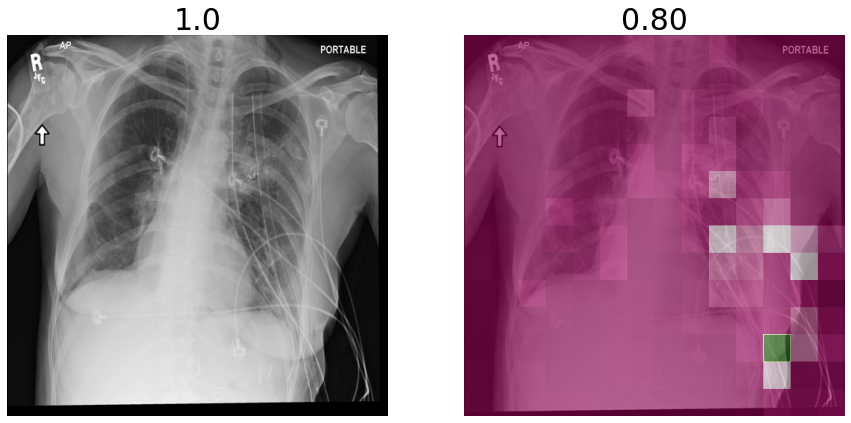

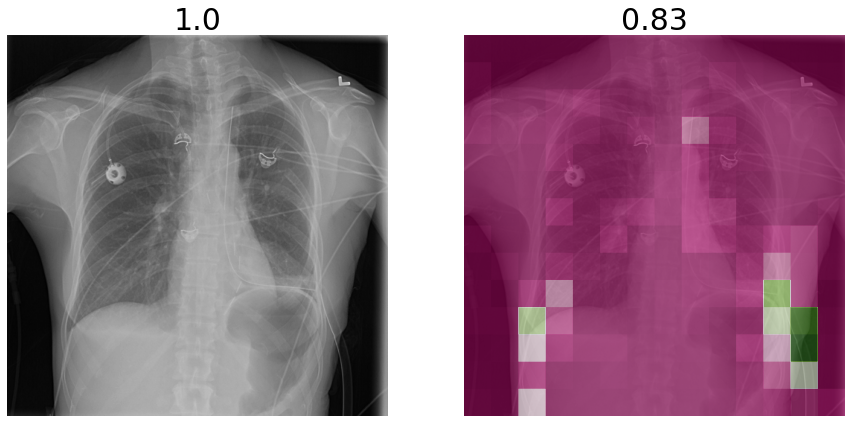

In [25]:
vis_scribble_preds(test_dp_sorted[-2:])